In [2]:
import numpy as np
import porepy as pp
import scipy.sparse as sps
import math 
import sys
sys.path.append("../class")
from Flow_class import Flow
from Transport_class import Transport
from Reaction_class import Reaction

In [3]:
Nx=100
Ny=5

In [4]:
#gb= pp.grid_buckets_2d.single_vertical([Nx, Ny], y_endpoints=[0.6, 0.2], simplex=False)
#gb, domain = pp.grid_buckets_2d.single_horizontal([Nx, Ny], x_endpoints=[0.2, 0.8], simplex=False)
#print(domain)
#pp.plot_grid(gb,figsize=[15,12])
#domain={'xmin': 0, 'xmax': 1, 'ymin': 0, 'ymax': 1}




In [6]:
# Point coordinates, as a 2xn array
p = np.array([[0.02,0.02,0.03,0.03], [0,0.005,0.005,0.01]])
# Point connections as a 2 x num_frac arary
e = np.array([[0, 2], [1, 3]])

# The domain contains two fractures: The first from (0, 0) - (2,0), the second (1, 0) to (1, 1)
# Set domain boundaries
domain = {'xmin': 0, 'xmax': 0.045, 'ymin': 0, 'ymax': 0.01}

# Define a fracture network in 2d
network_2d = pp.FractureNetwork2d(p,  domain)

# Set preferred mesh size close to the fracture, and at the boundary (essentially this is a far-field value)
#mesh_args = {'mesh_size_frac': 0.002, 'mesh_size_bound': 0.003}
mesh_args = {'mesh_size_frac': 0.002, 'mesh_size_bound': 0.003}


# Generate a mixed-dimensional mesh
gb = network_2d.mesh(mesh_args)
pp.plot_grid(gb,figsize=(15,12))

AttributeError: 'dict' object has no attribute 'shape'

In [5]:
parameter_flow={"aperture":1e-3,
           #"fracture_perm":1e-20,
            "fracture_perm":1e-8,
          #"fracture_perm_2":1e5,
           #"fracture_perm":1e5,
          #"fracture_perm":0.001,
           #"perm":1.0e-9,
           #"perm":2e-10,
           "perm":1e-10,
          #"f_lambda":lambda x,y,z:math.pi*math.pi*2*math.sin(math.pi*x)*math.sin(math.pi*y),
          "f_lambda":lambda x,y,z:0.0,
          "bc_value":[15.0,0.0],
          #"bc_value":[5.0e-9,0.0],
           #"bc_value":[0.0,0.0],
          "bc_type":['dir','dir'],
          "method":"Tpfa"}

k
[1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e

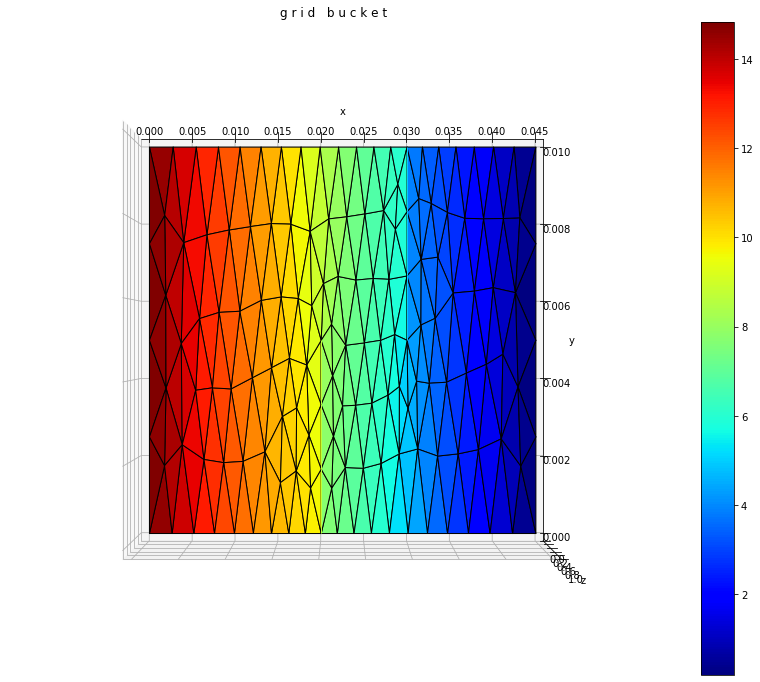

In [6]:
flow=Flow(gb,domain,parameter_flow)
#flow.add_data()
flow.set_data()
flow.discretize()
flow.solve()
flow.plot_pressure()

In [7]:
parameter={
    "aperture":1e-3,
    "por":0.3,
    #"por_frac":0.00001,
    "por_frac":0.05,
    #"por":1.0,
    #"por_frac":1.0,
    #"time_step":1 / 60,
    "time_step":34.56,
    #"time_step":0.001,
    #"t_max":1 /3,
    "t_max":345600,
    #"t_max":0.1,
    "initial_cond":lambda x,y,z:0.0}

transport=Transport(gb,domain,parameter)

In [8]:
Ca_value=[0.0,0.0]
Ca_type=['dir','dir']
CaSiO3_value=[0.0,0.0]
CaSiO3_type=['dir','dir']
Ca="Ca"
CaSiO3="CaSiO3"

In [9]:
reaction_data={"temperature":423,
       "A":1.9e-2,
       #"rate_const":0.00446,
       "rate_const":0.0005,
       "E":4700,
       "R":8.314,
       "K_eq":10e9,
       "ph":3.5,
       "mass_weight":0.3*1.0}
reaction=Reaction(reaction_data)
reaction.set_const_rate()
print(reaction.const_rate)

2.4964205820053154e-06


In [10]:
transport.set_data(Ca_value,Ca_type,Ca)
transport.get_flux(Ca)
transport.discretize(Ca)
lhs_Ca,rhs_source_adv_Ca,rhs_mass_Ca,assembler_Ca=transport.get_transport_lhs_rhs(Ca)
#ciao?1



P0_flux
[[ 2.83708450e-08  2.90349272e-08  2.73920594e-08  2.52428940e-08
   2.84958066e-08  2.84100580e-08  2.46789023e-08  3.35150525e-08
   2.79979326e-08  3.05221127e-08  3.73492991e-08  3.13289087e-08
   3.30134469e-08  1.30238480e-08  3.01461735e-08  2.96029112e-08
   1.25264545e-08  1.34669915e-08  2.12127753e-08  3.33849782e-08
   2.28849112e-08  3.35226924e-08  2.95877866e-08  3.53390178e-08
   3.08687432e-08  1.71388396e-08  3.00888953e-08  3.79220987e-08
   2.93200517e-08  3.48930251e-08  2.68072123e-08  2.87049634e-08
   3.07475837e-08  3.69802011e-08  2.47959218e-08  2.38967770e-08
   2.40772739e-08  2.75013075e-08  3.33026180e-08  2.40607881e-08
   2.90522812e-08  3.07812730e-08  2.99524795e-08  3.01309178e-08
   2.93717580e-08  2.46562337e-08  3.17776091e-08  2.91198315e-08
   2.96595092e-08  3.56503413e-08  2.62853272e-08  3.28414104e-08
   2.86443644e-08  3.74049326e-08  2.96495896e-08  3.37009769e-08
   3.59910643e-08  3.76086772e-08  2.89642348e-08  3.51043934e-08
  

/home/dell/anaconda3/lib/python3.8/site-packages/porepy/viz/plot_grid.py:127: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


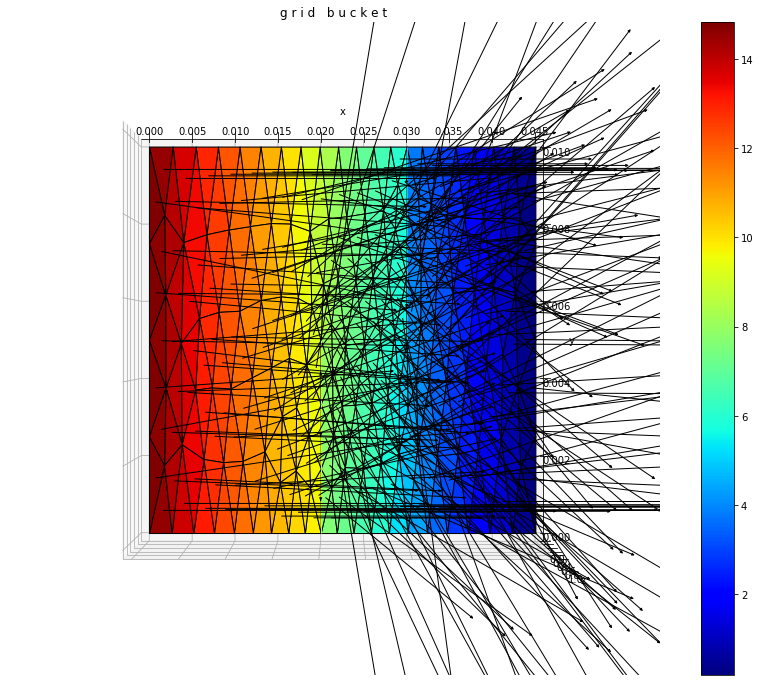

In [11]:
## to export the flux
key='Ca'
flux='darcy_flux'
mortar='mortar_flux'
flux_P0="P0_flux"

discr_P0_flux = pp.MVEM(key)
for g, d in gb:
    discr_P0_flux.discretize(g, d)
    d[pp.STATE][flux] = d[pp.PARAMETERS][key][flux]

## construct the P0 flux reconstruction
pp.project_flux(gb, discr_P0_flux, flux, flux_P0, mortar)

for g,d in gb:
    print("P0_flux")
    print(d[pp.STATE]["P0_flux"])

for g,d in gb:
    print("pressure")
    print(d[pp.STATE]["pressure"])
    
for g,d in gb:
    d[pp.STATE]["P0_flux"]*=1000000
pp.plot_grid(gb,"pressure","P0_flux",figsize=(15,12))

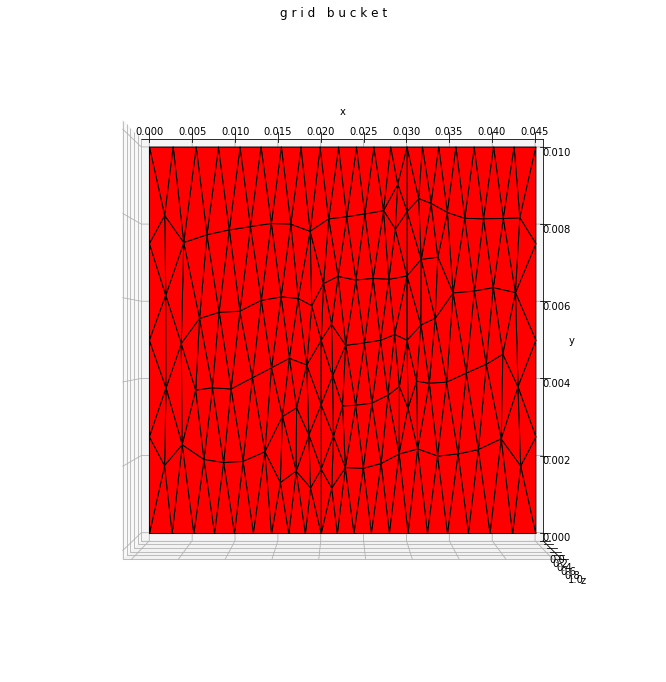

In [12]:
# Point coordinates, as a 2xn array
p = np.array([[0.02,0.02,0.03,0.03], [0,0.005,0.005,0.01]])
# Point connections as a 2 x num_frac arary
e = np.array([[0, 2], [1, 3]])

# The domain contains two fractures: The first from (0, 0) - (2,0), the second (1, 0) to (1, 1)
# Set domain boundaries
domain = {'xmin': 0, 'xmax': 0.045, 'ymin': 0, 'ymax': 0.01}

# Define a fracture network in 2d
network_2d = pp.FractureNetwork2d(p, e, domain)

# Set preferred mesh size close to the fracture, and at the boundary (essentially this is a far-field value)
#mesh_args = {'mesh_size_frac': 0.002, 'mesh_size_bound': 0.003}
mesh_args = {'mesh_size_frac': 0.002, 'mesh_size_bound': 0.003}


# Generate a mixed-dimensional mesh
gb1= network_2d.mesh(mesh_args)
pp.plot_grid(gb,figsize=(15,12))

In [13]:
parameter={"aperture":1e-3,
           #"fracture_perm":1e-20,
           "fracture_perm":1e-8,
           #"fracture_perm_2":1e5,
           #"fracture_perm":1e5,
          #"fracture_perm":0.001,
           #"perm":1.0e-9,
           #"perm":2e-10,
           "perm":1e-10,
          #"f_lambda":lambda x,y,z:math.pi*math.pi*2*math.sin(math.pi*x)*math.sin(math.pi*y),
          "f_lambda":lambda x,y,z:0.0,
          #"bc_value":[10.0,0.0],
          #"bc_value":[5.0e-9,0.0],
          "bc_value":[0.0,0.0],
          "bc_type":['dir','dir'],
          "method":"Tpfa"}

k
[1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
 1.e

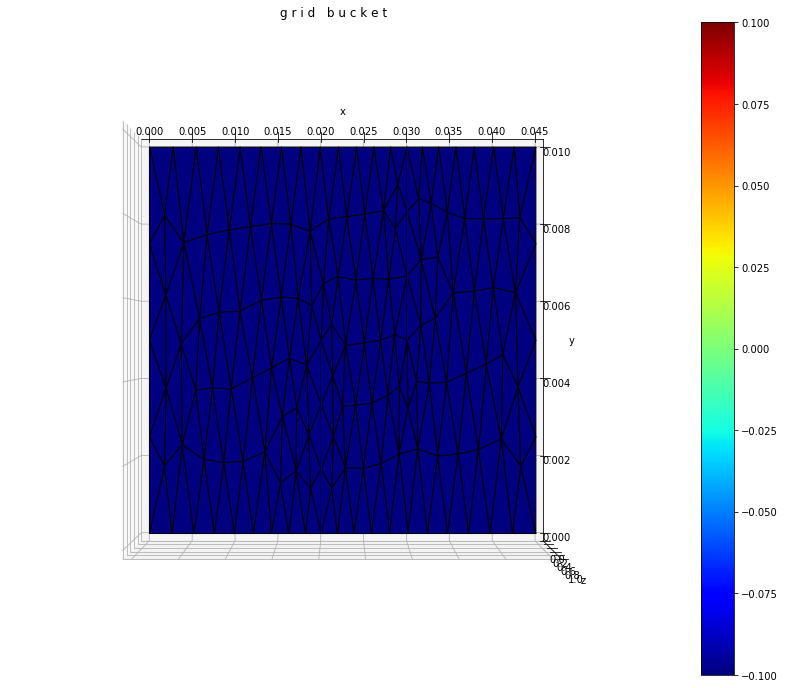

In [14]:
flow=Flow(gb1,domain,parameter)
#flow.add_data()
flow.set_data()
flow.discretize()
flow.solve()
flow.plot_pressure()

In [15]:
parameter={
    "aperture":1e-3,
    "por":0.3,
    #"por_frac":0.00001,
    "por_frac":0.05,
    #"por":1.0,
    #"por_frac":1.0,
    #"time_step":1 / 60,
    "time_step":34.56,
    #"time_step":0.001,
    #"t_max":1 /3,
    "t_max":345600,
    #"t_max":0.1,
    "initial_cond":lambda x,y,z:0.0}

transport_CaSiO3=Transport(gb1,domain,parameter)

In [16]:
transport_CaSiO3.set_data(CaSiO3_value,CaSiO3_type,CaSiO3)
transport_CaSiO3.get_flux(CaSiO3)    
transport_CaSiO3.discretize(CaSiO3)
lhs_CaSiO3,rhs_source_adv_CaSiO3,rhs_mass_CaSiO3,assembler_CaSiO3=transport_CaSiO3.get_transport_lhs_rhs(CaSiO3)

In [17]:
save_every = 100
n_steps = int(np.round(parameter["t_max"] / parameter["time_step"]))

# Initial condition
tracer1 = np.zeros(rhs_source_adv_Ca.size)
assembler_Ca.distribute_variable(
    tracer1, variable_names=[Ca,transport.mortar_variable+Ca]
)

#tracer2 = 16.7504*np.ones(rhs_source_adv_CaSiO3.size)
tracer2=np.zeros(rhs_source_adv_CaSiO3.size)
l=0
for g,d in gb:
    if(g.dim == gb.dim_max()):
        for j in range(g.num_cells):
            tracer2[j]=58.6264
        l=g.num_cells
    else:
        for i in range(l,l+g.num_cells,1):
            print("i")
            print(i)
            #tracer2[i]=251231
            tracer2[i]=477.3869
        l+=g.num_cells

assembler_CaSiO3.distribute_variable(
    tracer2, variable_names=[CaSiO3,transport.mortar_variable+CaSiO3]
)

# Exporter
exporter1 = pp.Exporter(gb, file_name="Ca", folder_name="Ca")
export_field1 = ["Ca"]
IEsolver_Ca = sps.linalg.factorized(lhs_Ca)

exporter2= pp.Exporter(gb1, file_name="CaSiO3", folder_name="CaSiO3")
export_field2 = ["CaSiO3"]
IEsolver_CaSiO3 = sps.linalg.factorized(lhs_CaSiO3)

i
246
i
247
i
248
i
249
i
250
i
251


/home/dell/.local/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


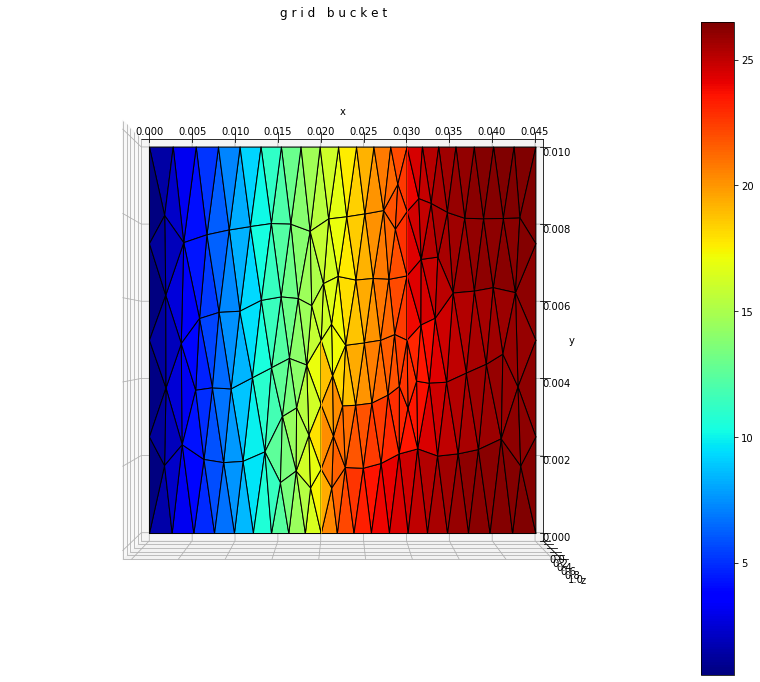

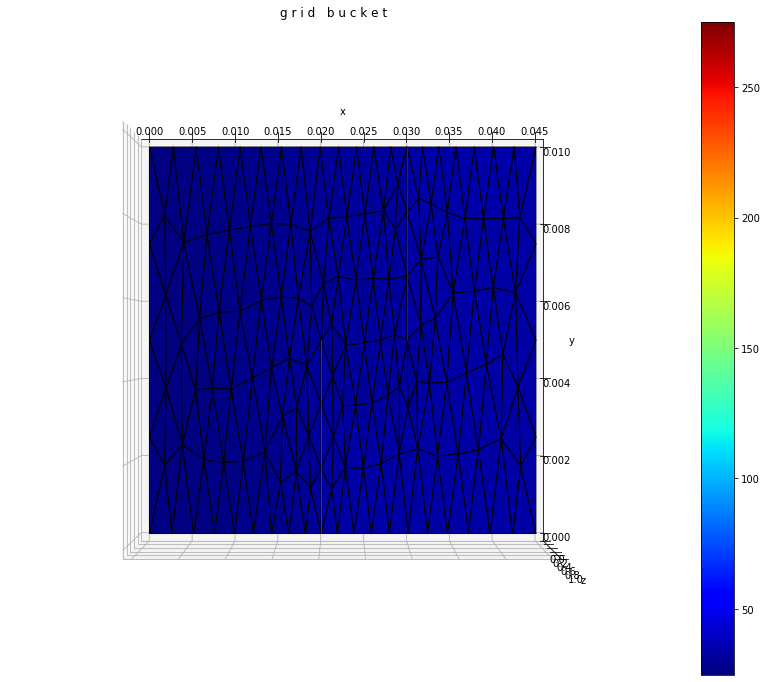

In [18]:
rd=np.zeros(tracer1.size)
#for i in range(10):
#for i in range(n_steps):


for i in range(1,n_steps+1,1):
    rd=reaction.compute_rd(tracer1,rd)
    if np.isclose((i-1) % save_every, 0):
            exporter1.write_vtu(export_field1, time_step=int((i-1) // save_every))
            exporter2.write_vtu(export_field2, time_step=int((i-1) // save_every))
            #for g,d in gb:
                #print("Ca")
                #print(d[pp.STATE]["Ca"])
            #for g,d in gb1:
                #print("CaSiO3")
                #print(d[pp.STATE]["CaSiO3"])
            #print("FINE")
            #print("rd")
            #print(rd)
    
    #rd=reaction.compute_rd(tracer1,rd)
    tracer1 = IEsolver_Ca(rhs_mass_Ca * tracer1 + rhs_source_adv_Ca+rhs_mass_Ca*rd*tracer2*parameter["time_step"])
    tracer2 = IEsolver_CaSiO3(rhs_mass_Ca * tracer2 + rhs_source_adv_CaSiO3-rhs_mass_CaSiO3*rd*tracer2*parameter["time_step"])
    #tracer1 = IEsolver_Ca(rhs_mass_Ca * tracer1 + rhs_source_adv_Ca)
    #tracer2 = IEsolver_CaSiO3(rhs_mass_Ca * tracer2 + rhs_source_adv_CaSiO3)
    
    
    assembler_Ca.distribute_variable(
        tracer1,
        variable_names=[Ca,transport.mortar_variable+Ca],
    )
    assembler_CaSiO3.distribute_variable(
        tracer2,
        variable_names=[CaSiO3,transport.mortar_variable+CaSiO3],
    )
    #print("tracer1")
    #print(tracer1)
    
exporter1.write_vtu(export_field1, time_step=(n_steps // save_every))
time_steps = np.arange(
    0, parameter["t_max"] + parameter["time_step"], save_every * parameter["time_step"]
)
    
exporter2.write_vtu(export_field2, time_step=(n_steps // save_every))
time_steps = np.arange(
    0, parameter["t_max"] + parameter["time_step"], save_every * parameter["time_step"]
)
exporter1.write_pvd(time_steps)
exporter2.write_pvd(time_steps)
transport.plot_tracer(Ca)
transport_CaSiO3.plot_tracer(CaSiO3)

In [19]:
print(transport.mortar_variable)

mortar_tracer


In [20]:
for g,d in gb:
    print("k_size:")
    print(d[pp.PARAMETERS]["flow"]["second_order_tensor"].values.size)
    print("Ca_size:")
    print(d[pp.STATE]["Ca"].size)
    print("fine")

k_size:
2214
Ca_size:
246
fine
k_size:
27
Ca_size:
3
fine
k_size:
27
Ca_size:
3
fine


In [21]:
a=4
for i in range(4):
    print(i)
print("fine")
for i in range(a,7,1):
    print(i)

0
1
2
3
fine
4
5
6


In [22]:
for g,d in gb1:
    print(d[pp.STATE]["CaSiO3"])

[27.96803773 28.29852523 33.50273433 32.02316835 27.55369211 27.10691476
 28.63314025 29.1811724  33.45356047 32.63326855 29.4628977  30.75939067
 32.86026118 32.12527992 30.88567524 27.32020233 30.3913981  33.14152474
 31.99183205 32.81474398 30.07609951 30.65256831 31.51377999 33.33703837
 30.94314868 33.51061951 26.97487677 29.65420247 32.96401176 29.1685978
 33.48564246 26.90865654 33.31123581 33.28273134 31.64951184 29.37367208
 33.23614521 31.45534052 30.33039336 33.19155231 32.49588604 33.22377582
 27.40326939 33.28205015 33.36413182 29.0196504  30.61886796 32.85772853
 32.95231945 29.75910772 33.2511792  28.85328898 31.31938296 32.61272145
 25.77247887 33.34774325 30.40342656 32.55746788 33.44948609 30.05601233
 33.21522714 26.07929487 33.34695481 28.79502047 32.8251592  33.27204825
 25.03889334 26.84028436 32.92041979 26.13632877 28.84661548 31.40892943
 28.43123644 29.48372697 32.63984693 33.31605409 25.17781782 33.31014217
 32.96375893 28.49919891 33.22159323 31.1731781  30.